In [13]:
import numpy as np
np.random.seed(0)
import visclassifier
import matplotlib.pyplot as plt
#new torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from l2distance import l2distance


In [14]:
def gen_regression_data(num_samples = 10000, ndims=1):
    # generate random x samples for training and test sets
    xTr = torch.rand(num_samples, ndims)
    xTe = torch.rand(int(num_samples * 0.1), ndims)
    
    # construct random w and b vectors
    gt_w = torch.randn(ndims, 1)
    gt_b = torch.randn(1)
    
    # gaussian noise for linear regression
    noise = np.random.rand(num_samples, 1) * 0.2
    test_noise = np.random.rand(int(num_samples * 0.1), 1) * 0.2
    
    # add noise on the labels for the training set
    yTr = xTr @ gt_w + gt_b + noise
    yTe = xTe @ gt_w + gt_b + test_noise
    
    return xTr, xTe, yTr, yTe, gt_w, gt_b

In [15]:
lr_xTr, lr_xTe, lr_yTr, lr_yTe, gt_w, gt_b = gen_regression_data(num_samples = 1000, ndims=1)

In [16]:
class LinearRegressionModel(nn.Module):
    def __init__(self, ndims):
        super(LinearRegressionModel, self).__init__()
        """ pytorch optimizer checks for the properties of the model, and if
            the torch.nn.Parameter requires gradient, then the model will update
            the parameters automatically.
        """
        self.w = nn.Parameter(torch.randn(ndims, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)
    
    def forward(self, x):
        return x @ self.w + self.b

In [17]:
def mse_loss(y_pred, y_true):
    square_diff = torch.square((y_pred-y_true))
    mean_error = 0.5 * torch.mean(square_diff)
    return mean_error

In [18]:
def train_regression_model(xTr, yTr, num_epochs, reg_param, lr=1e-2, print_freq=100):
    ndims = xTr.shape[1]
    
    model = LinearRegressionModel(ndims)  # initialize the model
    optimizer = optim.SGD(model.parameters(), lr=lr)  # create an SGD optimizer for the model parameters
    
    for epoch in range(num_epochs):
        # need to zero the gradients in the optimizer so we don't
        # use the gradients from previous iterations
        optimizer.zero_grad()  
        pred = model.forward(xTr)  # compute model predictions
        loss = mse_loss(pred, yTr) + reg_param * torch.norm(model.w)
        loss.backward()  # compute the gradient wrt loss
        optimizer.step()  # performs a step of gradient descent
        if (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))
    
    return model  # return trained model

In [19]:
model = train_regression_model(lr_xTr, lr_yTr, num_epochs=2000, reg_param=0.001, lr=1e-2)
avg_test_error = mse_loss(model.forward(lr_xTe), lr_yTe)
print('avg test error', avg_test_error.item())

epoch 100 loss 0.0407576384085779
epoch 200 loss 0.025768407820415656
epoch 300 loss 0.02192967946169245
epoch 400 loss 0.019280980425161735
epoch 500 loss 0.017017385864487467
epoch 600 loss 0.015040536657362439
epoch 700 loss 0.01331078724346224
epoch 800 loss 0.011848805173060388
epoch 900 loss 0.01064164300345529
epoch 1000 loss 0.009585262642790823
epoch 1100 loss 0.008660763542463418
epoch 1200 loss 0.00785167635893183
epoch 1300 loss 0.0071435903595398675
epoch 1400 loss 0.006523899065448696
epoch 1500 loss 0.005981566700267257
epoch 1600 loss 0.005506936522460374
epoch 1700 loss 0.005091554724502329
epoch 1800 loss 0.0047280251707326375
epoch 1900 loss 0.004409881563703969
epoch 2000 loss 0.004131453348186214
avg test error 0.004714337853406378


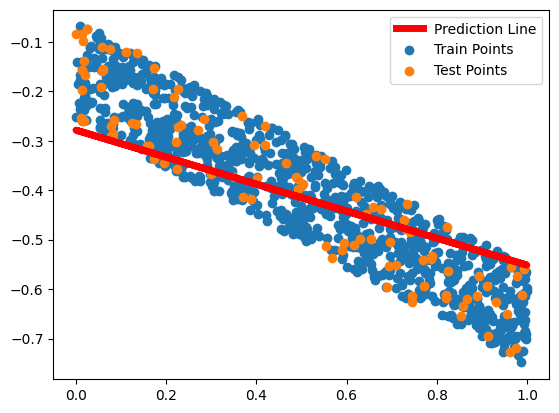

In [20]:
plt.plot(lr_xTr, model.forward(lr_xTr).detach(),linewidth=5.0, color="red", label="Prediction Line")
plt.scatter(lr_xTr, lr_yTr, label="Train Points")
plt.scatter(lr_xTe, lr_yTe, label="Test Points")
plt.legend()
plt.show()

In [ ]:
def genrandomdata(n=100,b=0.):
    # generate random data and linearly separable labels
    xTr = np.random.randn(n, 2)
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return torch.from_numpy(xTr).float(), torch.from_numpy(yTr).float()

def generate_noisy_data(N=1000):
    """ 
    Generates two clusters of data with a small amount of noise.
    The clusters are centered at (0,0) and (1,1) respectively.
    They have a significant amount of overlap.

    Returns:
    --------
    x: torch.Tensor
    y: torch.Tensor
    """
    mean1 = torch.tensor([0, 0], dtype=torch.float32)
    cov1 = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
    
    x1 = torch.distributions.multivariate_normal.MultivariateNormal(mean1, cov1).sample((N,))
    y1 = torch.ones((N,), dtype=torch.float32)

    mean2 = torch.tensor([1, 1], dtype=torch.float32)
    cov2 = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
    
    x2 = torch.distributions.multivariate_normal.MultivariateNormal(mean2, cov2).sample((N,))
    y2 = -torch.ones((N,), dtype=torch.float32)

    return torch.cat((x1, x2), dim=0), torch.cat((y1, y2), dim=0)

def generate_imbalanced_data(N=1000):
    """ 
    Generates two clusters of data with a small amount of noise.
    The cluserts share the same mean and covariance.
    One class has a much higher probability of being sampled than the other.

    Returns:
    --------
    x: torch.Tensor
    y: torch.Tensor
    """
    n_features = 2
    labels = torch.distributions.Binomial(total_count=1, probs=0.1).sample((N,)).float()
    labels = 2 * labels - 1  # convert 0s to -1s and 1s to 1s
    return torch.randn((N, n_features)), labels

def generate_high_dim_data(N=1000, n_features=6):
    """
    Generates high dimensional data with a small amount of noise.
    No clusters are present. # / TODO change this
    Returns:
    --------
    x: torch.Tensor
    y: torch.Tensor
    
    """
    return torch.randn((N, n_features)), torch.tensor(torch.distributions.Bernoulli(torch.tensor(0.5)).sample((N,)), dtype=torch.float32)

def generate_spiral_data(N=1000):
    r = torch.linspace(1, 2 * np.pi, N)
    
    X1 = torch.stack([torch.sin(2. * r) * r, torch.cos(2 * r) * r], dim=1)
    X2 = torch.stack([torch.sin(2. * r + np.pi) * r, torch.cos(2 * r + np.pi) * r], dim=1)
    
    X_final = torch.cat([X1, X2], dim=0)
    
    y = torch.cat([torch.ones(N, dtype=torch.float32), -torch.ones(N, dtype=torch.float32)])
    
    X_final = X_final + torch.randn(X_final.shape) * 0.2
    
    return X_final, y

def generate_block_data(N=1000, x1_min=-10, x1_max=10, x2_min=0, x2_max=5, B=6):
    x1_range = x1_max - x1_min
    h = x1_range / B

    X = torch.zeros((N, 2))
    y = torch.ones(N)

    X[:, 1] = torch.distributions.Uniform(torch.tensor(x2_min, dtype=torch.float32), 
                                            torch.tensor(x2_max, dtype=torch.float32)).sample((N,))
    
    X[:,0] = torch.linspace(x1_min, x1_max, N)
    x1_intervals = torch.linspace(x1_min, x1_max, B+1)
    
    for i in range(B):
        mask = ((X[:, 0] >= x1_intervals[i]) & (X[:, 0] < x1_intervals[i+1]))
        y[mask] = -1 if i % 2 == 1 else 1

        X_block = X[mask, :]
        X_block[:, 0] = x1_intervals[i] + torch.rand((X_block.shape[0],)) * h
        
        X[mask, :] = X_block

    return X, y

def generate_test_set():
    X = torch.tensor([[ 9.8190e-01, -1.9403e+00],
        [ 9.6209e-01, -2.3319e+00],
        [ 1.8149e+00, -4.3748e-01],
        [ 5.1416e-01,  8.4826e-02],
        [ 9.0824e-01, -6.9821e-01],
        [ 5.0559e-01, -7.6698e-01],
        [ 2.0092e+00, -9.0732e-01],
        [ 5.3011e-01, -1.0825e+00],
        [ 9.1786e-01, -1.2054e+00],
        [-9.8073e-01, -1.5143e+00],
        [ 4.6092e-01, -2.3650e+00],
        [-3.2885e-01, -1.1056e+00],
        [ 1.1280e-01, -7.4153e-01],
        [ 1.0395e+00, -2.9701e+00],
        [-6.8324e-01, -1.7713e+00],
        [ 5.7636e-01, -2.0069e+00],
        [-7.7056e-01, -1.4585e+00],
        [-1.0506e+00, -1.6165e+00],
        [-6.9592e-05, -1.1993e-01],
        [-9.2461e-02, -1.8610e+00],
        [ 7.8143e-01, -1.4488e+00],
        [ 8.3535e-01, -1.3578e+00],
        [-8.8179e-01, -1.8517e+00],
        [-1.4639e+00, -2.3710e+00],
        [-8.8477e-01, -1.6390e+00],
        [-1.6018e+00, -1.1389e+00],
        [-6.4307e-01, -1.5868e+00],
        [-1.6026e+00, -8.8822e-01],
        [-2.3038e-01, -2.1629e+00],
        [-2.6553e+00, -1.8649e+00],
        [-3.1486e+00, -1.4674e+00],
        [-1.2511e+00, -1.4477e+00],
        [-3.8619e-01,  5.2266e-01],
        [-4.5169e-01, -5.9312e-01],
        [-2.4075e+00, -2.0097e-02],
        [-2.6175e+00, -9.8655e-01],
        [-3.3039e+00, -1.1503e-01],
        [-2.6369e+00, -8.6823e-01],
        [-2.7704e+00, -1.4237e+00],
        [-1.3674e+00,  4.3688e-01],
        [-1.4993e+00,  2.4715e-01],
        [-1.6360e+00,  2.6006e-01],
        [-2.0943e+00,  1.0533e+00],
        [-3.2593e+00,  2.3918e+00],
        [-2.2136e+00,  4.1211e-01],
        [-2.4322e+00,  1.5895e+00],
        [-2.6210e+00,  1.5934e+00],
        [-1.2136e+00,  7.9794e-01],
        [-1.6874e+00,  1.8192e+00],
        [-2.9591e+00,  1.2397e+00],
        [-1.1128e+00,  1.4130e+00],
        [-2.0218e+00,  1.8360e+00],
        [-4.2503e-01,  1.0452e+00],
        [-1.9478e+00,  2.8479e+00],
        [-1.2956e+00,  3.4505e+00],
        [-2.9251e-01,  4.9850e+00],
        [-1.8452e+00,  2.3631e+00],
        [ 1.1352e-01,  2.7473e+00],
        [-2.0592e+00,  2.3869e+00],
        [-1.0319e-01,  3.5952e+00],
        [ 1.1203e-01,  2.9230e+00],
        [-3.7333e-01,  2.4870e+00],
        [ 1.7929e+00,  4.4269e+00],
        [ 1.4197e+00,  3.5101e+00],
        [ 4.2491e-01,  3.6740e+00],
        [ 1.6359e+00,  3.8732e+00],
        [ 2.5397e+00,  5.6812e+00],
        [ 6.2802e-01,  2.7992e+00],
        [ 1.8957e+00,  3.8032e+00],
        [ 1.7104e+00,  2.5512e+00],
        [ 1.3910e+00,  1.0086e+00],
        [ 8.2790e-01,  2.4820e+00],
        [ 6.5166e-01,  2.2973e+00],
        [ 2.6612e+00,  9.5956e-01],
        [ 4.2811e+00,  1.7075e+00],
        [ 2.9373e+00,  1.3144e+00],
        [ 1.8810e+00,  1.7362e-01],
        [ 4.2198e+00,  1.2135e+00],
        [ 3.2064e+00,  2.9063e-01],
        [ 3.8143e+00,  1.7187e+00],
        [ 3.5129e+00,  1.4251e+00],
        [ 3.8539e+00,  2.3800e-01],
        [ 2.8589e+00, -3.4205e-01],
        [ 4.9826e+00,  1.1277e+00],
        [ 2.6128e+00, -6.3528e-01],
        [ 5.0181e+00, -6.3613e-01],
        [ 4.4582e+00,  2.1560e-01],
        [ 4.7599e+00, -1.8506e+00],
        [ 2.1224e+00, -6.7995e-01],
        [ 2.7577e+00, -2.1554e+00],
        [ 4.5814e+00, -1.8412e+00],
        [ 3.5139e+00, -1.9548e+00],
        [ 2.0412e+00, -8.6512e-01],
        [ 2.3261e+00, -2.4993e+00],
        [ 2.1649e+00, -1.8686e+00],
        [ 4.1195e+00, -3.9764e+00],
        [ 3.1155e+00, -3.1719e+00],
        [ 1.2533e+00, -3.8363e+00],
        [ 1.8363e+00, -4.3865e+00],
        [ 1.1995e+00, -3.2019e+00],
        [ 1.6461e+00, -3.2146e+00],
        [ 7.9420e-01, -5.5684e+00],
        [ 2.1164e-01, -4.8594e+00],
        [ 7.7001e-01, -4.0540e+00],
        [-6.4925e-01, -4.8531e+00],
        [-1.5667e-01, -4.7256e+00],
        [-8.3327e-01, -4.1433e+00],
        [-1.0600e+00, -4.8758e+00],
        [ 9.7460e-02, -4.0436e+00],
        [-3.5471e+00, -5.4139e+00],
        [-1.6674e+00, -3.0487e+00],
        [-1.9889e+00, -3.8193e+00],
        [-3.8267e+00, -4.1029e+00],
        [-3.3167e+00, -2.6150e+00],
        [-2.2595e+00, -4.6763e+00],
        [-3.5747e+00, -3.4356e+00],
        [-2.5963e+00, -2.8938e+00],
        [-3.8395e+00, -3.1494e+00],
        [-4.3063e+00, -3.0907e+00],
        [-4.4310e+00, -3.0110e+00],
        [-3.0232e+00, -1.8533e+00],
        [-4.4502e+00, -2.9611e+00],
        [-4.6164e+00, -1.7275e+00],
        [-3.6731e+00, -2.4114e+00],
        [-5.9522e+00, -2.1749e+00],
        [-5.5098e+00, -1.2369e+00],
        [-6.2248e+00,  4.1390e-01],
        [-6.3680e+00,  2.0144e-02],
        [-6.2401e+00,  2.8986e-01],
        [-5.1582e+00,  1.2739e+00],
        [-7.0608e+00,  6.1121e-01],
        [-4.8753e+00,  3.1750e+00],
        [-4.8379e+00,  2.7960e+00],
        [-5.6074e+00,  2.3188e+00],
        [-4.7002e+00,  1.0153e+00],
        [-5.6410e+00,  2.2509e+00],
        [-4.3411e+00,  3.7383e+00],
        [-3.5810e+00,  3.8008e+00],
        [-3.3323e+00,  4.4542e+00],
        [-3.5937e+00,  5.2938e+00],
        [-4.0219e+00,  5.0537e+00],
        [-3.9847e+00,  5.5378e+00],
        [-3.4602e+00,  3.2985e+00],
        [-1.7157e+00,  4.9793e+00],
        [-3.5114e+00,  6.8594e+00],
        [-2.0740e+00,  5.7828e+00],
        [-1.4186e+00,  5.8624e+00],
        [-9.6828e-01,  6.0783e+00],
        [ 3.3013e-01,  5.6911e+00],
        [ 3.6760e-01,  6.7389e+00],
        [-7.5075e-01,  2.5611e-01],
        [-1.1335e+00,  1.0515e+00],
        [-1.4097e+00,  8.4411e-01],
        [ 1.0298e-01,  1.2910e+00],
        [-8.8046e-01, -2.7643e-01],
        [-6.4999e-02,  7.5835e-01],
        [-2.9755e-01,  7.3798e-01],
        [-3.5308e-01,  2.7253e-01],
        [-5.9112e-01,  1.2621e+00],
        [ 1.1422e+00,  2.2262e+00],
        [ 1.7153e-01,  2.1843e+00],
        [-3.2299e-01,  1.7094e+00],
        [-8.4639e-01,  2.2879e-01],
        [-6.0378e-01,  1.5946e-01],
        [-5.2534e-01,  2.1538e+00],
        [ 6.6751e-01,  2.0719e+00],
        [-2.9110e-01,  1.5164e+00],
        [ 1.1295e+00,  8.7016e-01],
        [ 4.1551e-01,  1.3468e+00],
        [ 7.9465e-01,  2.4672e+00],
        [ 1.2728e+00,  1.2246e+00],
        [ 1.1006e-01,  4.2868e-01],
        [ 1.1992e+00,  3.3767e+00],
        [ 1.5814e+00,  1.2833e+00],
        [ 9.9237e-01,  5.7171e-01],
        [ 1.5774e+00,  1.6055e+00],
        [ 4.5601e-01,  1.8986e+00],
        [ 8.1456e-01,  4.1951e-01],
        [ 1.6836e+00,  9.2908e-01],
        [ 1.2115e+00,  1.3859e-01],
        [ 1.4414e+00,  5.0064e-01],
        [ 1.1103e+00, -3.6791e-01],
        [ 1.1119e+00,  9.2019e-01],
        [ 1.6403e+00,  1.3918e+00],
        [ 3.2364e+00,  1.9336e+00],
        [ 4.0590e+00,  1.0002e+00],
        [ 2.8508e+00,  4.2781e-01],
        [ 2.6445e+00,  1.9291e-01],
        [ 2.6779e+00, -3.5041e-01],
        [ 3.1076e+00,  1.4913e-01],
        [ 2.7880e+00,  2.1468e-01],
        [ 2.3014e+00, -1.4436e+00],
        [ 2.6590e+00,  4.1712e-01],
        [ 1.5259e+00, -1.5221e+00],
        [ 3.6041e+00, -4.8833e-01],
        [ 2.1626e+00, -3.2024e+00],
        [ 1.3605e+00,  4.2977e-01],
        [ 1.9267e+00, -9.5213e-01],
        [ 1.8179e+00, -2.7551e+00],
        [ 9.8809e-01, -1.4314e+00],
        [ 1.7292e+00, -2.1333e+00],
        [ 2.5091e+00, -2.9777e+00],
        [ 1.7884e+00, -1.1217e+00],
        [ 1.9023e+00, -3.3019e+00],
        [ 9.1473e-01, -3.1359e+00],
        [-2.1113e-02, -1.5490e+00],
        [ 1.6508e+00, -2.9889e+00],
        [ 1.2916e+00, -2.5829e+00],
        [ 1.7812e+00, -4.1576e+00],
        [-1.1525e+00, -2.6605e+00],
        [ 5.2886e-01, -1.4710e+00],
        [ 4.0298e-01, -3.2335e+00],
        [ 8.9324e-01, -3.9677e+00],
        [-1.0826e+00, -3.8529e+00],
        [-1.1475e+00, -3.1029e+00],
        [-7.1333e-01, -3.4775e+00],
        [-3.4693e-01, -2.0140e+00],
        [-1.9385e+00, -1.0962e+00],
        [-2.6509e+00, -3.1336e+00],
        [-1.6338e+00, -2.9240e+00],
        [-3.6470e+00, -2.4296e+00],
        [-1.8770e+00, -3.5006e+00],
        [-2.7030e+00, -1.3737e+00],
        [-2.6613e+00, -1.9308e+00],
        [-3.8759e+00, -2.7354e+00],
        [-3.9530e+00, -1.0243e+00],
        [-3.9302e+00, -2.6847e+00],
        [-3.2991e+00, -1.3622e+00],
        [-4.8243e+00,  2.7951e-02],
        [-2.7398e+00, -6.3898e-01],
        [-4.2845e+00, -3.2235e-01],
        [-5.0136e+00, -3.5962e-01],
        [-4.1221e+00,  2.0108e-01],
        [-4.3453e+00,  6.0861e-01],
        [-3.7565e+00,  1.0889e+00],
        [-4.0709e+00,  9.3234e-01],
        [-3.9990e+00,  9.8726e-01],
        [-3.8145e+00,  1.1593e+00],
        [-3.2917e+00,  2.1075e+00],
        [-4.4317e+00,  1.8842e+00],
        [-2.5716e+00,  2.0317e+00],
        [-3.5114e+00,  3.3525e+00],
        [-3.9159e+00,  3.9416e+00],
        [-1.8221e+00,  2.7240e+00],
        [-1.9107e+00,  2.4639e+00],
        [-1.9074e+00,  4.7483e+00],
        [-2.4940e+00,  3.8511e+00],
        [-2.3128e+00,  2.6827e+00],
        [-1.1506e+00,  4.1235e+00],
        [-2.1268e+00,  4.3956e+00],
        [-2.0951e+00,  4.1341e+00],
        [-1.7840e+00,  4.5595e+00],
        [ 3.2011e-03,  4.6935e+00],
        [ 7.5450e-01,  5.8475e+00],
        [-2.7324e-01,  5.8699e+00],
        [ 3.4909e-01,  3.0165e+00],
        [ 8.3790e-01,  5.0562e+00],
        [ 1.6375e+00,  6.1748e+00],
        [-8.0703e-01,  5.1293e+00],
        [ 1.0126e+00,  6.3081e+00],
        [ 2.1927e+00,  3.6736e+00],
        [ 2.9179e+00,  3.8663e+00],
        [ 2.8656e+00,  3.5375e+00],
        [ 4.1200e+00,  3.2113e+00],
        [ 4.0057e+00,  4.5579e+00],
        [ 1.4387e+00,  4.2905e+00],
        [ 2.8932e+00,  4.5882e+00],
        [ 5.0970e+00,  3.1514e+00],
        [ 3.0959e+00,  2.0646e+00],
        [ 4.0791e+00,  2.7931e+00],
        [ 3.4367e+00,  1.6602e+00],
        [ 5.3226e+00,  1.3800e+00],
        [ 4.8705e+00,  1.7135e+00],
        [ 5.0538e+00,  1.0627e+00],
        [ 4.8630e+00,  1.0693e+00],
        [ 5.6819e+00, -7.5253e-02],
        [ 5.1473e+00,  3.2511e-01],
        [ 6.2065e+00, -1.3081e+00],
        [ 5.9010e+00,  7.1119e-01],
        [ 4.7765e+00, -6.9646e-01],
        [ 6.2545e+00, -2.6897e+00],
        [ 5.3811e+00, -3.6138e-01],
        [ 6.7841e+00, -1.0508e+00],
        [ 4.7571e+00, -1.5827e+00],
        [ 4.7614e+00, -1.5183e+00],
        [ 3.8628e+00, -3.7785e+00],
        [ 4.5935e+00, -3.2142e+00],
        [ 4.4320e+00, -3.8701e+00],
        [ 4.0817e+00, -3.5649e+00],
        [ 3.0598e+00, -5.2407e+00],
        [ 3.5196e+00, -4.0034e+00],
        [ 3.5928e+00, -4.6666e+00],
        [ 1.5770e+00, -5.3793e+00],
        [ 9.5385e-01, -6.3997e+00],
        [ 2.3205e+00, -7.0438e+00],
        [ 2.9988e-01, -5.6360e+00],
        [ 1.5092e+00, -6.0911e+00],
        [ 1.4980e+00, -6.4944e+00],
        [ 3.1526e-02, -4.6067e+00],
        [ 8.7983e-01, -6.7945e+00]], dtype=torch.float64) 
        
    y =  torch.tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
    -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
    -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
    -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
    -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
    -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
    -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
    -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
    -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
    -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
    -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
    -1., -1., -1., -1., -1., -1.], dtype=torch.float64)

    return X, y

def generate_test_high_dim():
    X = torch.tensor([[ 1.3231e-02, -6.8143e+00,  2.3798e-01, -1.8478e+01,  6.7466e+00,
         -1.3501e+01],
        [-1.3653e-01, -6.8410e+00,  7.2934e-01, -1.8450e+01,  6.2326e+00,
         -1.3409e+01],
        [-3.5753e-01, -7.2981e+00,  1.2173e+00, -1.8059e+01,  6.8513e+00,
         -1.2658e+01],
        [-6.3261e-01, -6.8655e+00,  8.9887e-01, -1.8391e+01,  6.0277e+00,
         -1.3222e+01],
        [ 1.3680e-01, -7.5259e+00,  6.9664e-01, -1.8541e+01,  6.6198e+00,
         -1.2720e+01],
        [ 1.0872e+00, -7.3082e+00,  1.4844e+00, -1.7958e+01,  6.2021e+00,
         -1.2463e+01],
        [ 3.0755e-01, -7.1785e+00,  7.5163e-01, -1.8553e+01,  6.0178e+00,
         -1.2943e+01],
        [ 8.9673e-01, -7.2607e+00,  9.2561e-01, -1.8260e+01,  5.6563e+00,
         -1.3066e+01],
        [ 6.1027e-01, -7.6792e+00,  1.5164e+00, -1.8438e+01,  6.0146e+00,
         -1.2533e+01],
        [ 1.0440e+00, -7.6411e+00,  8.7135e-01, -1.8453e+01,  5.8052e+00,
         -1.2952e+01],
        [-7.1217e-01, -7.0948e+00,  5.5295e-01, -1.8027e+01,  5.9739e+00,
         -1.3073e+01],
        [-5.8277e-01, -7.8883e+00, -1.0940e-01, -1.8082e+01,  6.1379e+00,
         -1.2740e+01],
        [-1.2116e-01, -7.4979e+00, -3.7608e-01, -1.8196e+01,  6.2449e+00,
         -1.2446e+01],
        [-2.4237e-01, -7.4199e+00,  4.4857e-02, -1.7541e+01,  6.3889e+00,
         -1.3059e+01],
        [-1.5717e-01, -7.6543e+00,  1.7737e-01, -1.8367e+01,  6.3144e+00,
         -1.3023e+01],
        [-1.9799e-02, -7.3870e+00,  6.2506e-02, -1.7735e+01,  5.5975e+00,
         -1.2701e+01],
        [ 2.5966e-01, -6.8520e+00,  3.4229e-01, -1.8062e+01,  5.8174e+00,
         -1.2502e+01],
        [ 4.0161e-01, -7.3449e+00,  8.2635e-01, -1.7448e+01,  5.5475e+00,
         -1.3082e+01],
        [ 4.2571e-01, -7.4464e+00,  2.7278e-01, -1.7611e+01,  5.6232e+00,
         -1.1691e+01],
        [ 1.1030e-01, -7.9189e+00,  2.2447e-01, -1.7934e+01,  5.8180e+00,
         -1.2639e+01],
        [-8.2808e-02, -6.0220e+00,  1.2273e+00, -1.8205e+01,  6.8333e+00,
         -1.3834e+01],
        [-3.5205e-01, -6.2239e+00,  9.9038e-01, -1.7805e+01,  6.7317e+00,
         -1.3625e+01],
        [-4.3296e-01, -6.2189e+00,  1.0310e+00, -1.8201e+01,  6.4693e+00,
         -1.3641e+01],
        [-2.8166e-01, -6.5306e+00,  5.7654e-01, -1.8142e+01,  6.8989e+00,
         -1.3366e+01],
        [-1.2285e-01, -6.5626e+00,  1.2894e+00, -1.7595e+01,  6.6172e+00,
         -1.3436e+01],
        [ 7.4086e-01, -6.4102e+00,  1.0674e+00, -1.7618e+01,  6.1867e+00,
         -1.3242e+01],
        [ 5.1403e-01, -6.8271e+00,  9.3932e-01, -1.7413e+01,  5.5062e+00,
         -1.3190e+01],
        [ 3.8363e-01, -6.1093e+00,  8.2174e-01, -1.7881e+01,  5.6127e+00,
         -1.2838e+01],
        [ 4.5972e-01, -6.0616e+00,  1.1592e+00, -1.7725e+01,  5.0793e+00,
         -1.3104e+01],
        [ 2.8015e-01, -6.4089e+00,  9.1765e-01, -1.7906e+01,  5.5255e+00,
         -1.3223e+01],
        [-6.1427e-01, -6.9068e+00,  3.4589e-01, -1.7164e+01,  6.2148e+00,
         -1.2900e+01],
        [-3.7162e-01, -6.3278e+00,  2.4243e-01, -1.7767e+01,  6.1742e+00,
         -1.2957e+01],
        [-6.9497e-01, -6.6794e+00,  3.8368e-01, -1.7655e+01,  6.0975e+00,
         -1.3323e+01],
        [-4.2955e-01, -6.4944e+00,  2.4461e-01, -1.7280e+01,  6.1054e+00,
         -1.3184e+01],
        [-7.0163e-01, -6.3185e+00, -1.5071e-01, -1.7991e+01,  5.7390e+00,
         -1.3022e+01],
        [ 3.5006e-01, -7.0053e+00,  1.2109e-01, -1.7441e+01,  5.3405e+00,
         -1.3186e+01],
        [ 4.3838e-01, -6.5299e+00,  4.4879e-01, -1.7490e+01,  5.4492e+00,
         -1.2733e+01],
        [-6.1910e-02, -6.8888e+00, -2.5273e-01, -1.7764e+01,  5.2830e+00,
         -1.3045e+01],
        [-4.8325e-02, -6.7698e+00,  5.9518e-01, -1.7181e+01,  5.3777e+00,
         -1.3135e+01],
        [-2.6270e-04, -6.9785e+00,  5.3544e-01, -1.7436e+01,  5.6286e+00,
         -1.3310e+01],
        [ 5.7006e-01, -7.3865e+00,  7.9438e-01, -1.7545e+01,  7.7403e+00,
         -1.2787e+01],
        [ 6.7808e-01, -7.1492e+00,  6.9199e-01, -1.7510e+01,  7.2148e+00,
         -1.2547e+01],
        [ 4.3712e-01, -7.3120e+00,  1.1962e+00, -1.7663e+01,  7.3525e+00,
         -1.2754e+01],
        [ 2.5384e-01, -7.3976e+00,  8.8969e-01, -1.7633e+01,  7.1188e+00,
         -1.3311e+01],
        [ 5.3020e-01, -7.2431e+00,  7.0346e-01, -1.7448e+01,  6.9760e+00,
         -1.3057e+01],
        [ 1.1846e+00, -7.4336e+00,  7.6144e-01, -1.6817e+01,  6.4041e+00,
         -1.2733e+01],
        [ 7.2760e-01, -7.1833e+00,  1.4520e+00, -1.7700e+01,  6.6598e+00,
         -1.2658e+01],
        [ 1.5233e+00, -6.8879e+00,  1.0253e+00, -1.7582e+01,  6.5816e+00,
         -1.2721e+01],
        [ 6.0745e-01, -7.0490e+00,  1.1180e+00, -1.7445e+01,  6.7452e+00,
         -1.2703e+01],
        [ 9.5487e-01, -6.5536e+00,  1.5120e+00, -1.7264e+01,  7.0496e+00,
         -1.2534e+01],
        [-1.7748e-02, -8.1530e+00,  3.7140e-01, -1.7356e+01,  6.7839e+00,
         -1.2853e+01],
        [ 1.4654e-01, -7.5375e+00,  4.6952e-01, -1.7064e+01,  6.5307e+00,
         -1.2602e+01],
        [-1.8993e-01, -7.8870e+00,  6.5522e-01, -1.7252e+01,  6.3156e+00,
         -1.2564e+01],
        [-6.7595e-01, -6.9365e+00,  5.4108e-02, -1.6845e+01,  7.1107e+00,
         -1.2411e+01],
        [ 4.8764e-02, -7.4553e+00,  2.2888e-01, -1.7753e+01,  6.9822e+00,
         -1.2868e+01],
        [ 3.3425e-01, -7.8557e+00,  1.5378e-01, -1.7220e+01,  6.1469e+00,
         -1.2668e+01],
        [ 4.0729e-01, -7.3033e+00,  4.0836e-01, -1.7010e+01,  5.8717e+00,
         -1.2555e+01],
        [ 8.8097e-02, -7.4207e+00,  5.5111e-01, -1.6340e+01,  6.3227e+00,
         -1.2922e+01],
        [ 4.5702e-01, -7.5619e+00,  5.0669e-01, -1.7533e+01,  6.0980e+00,
         -1.2602e+01],
        [ 9.0617e-01, -7.6882e+00,  8.3852e-01, -1.7270e+01,  6.3751e+00,
         -1.2025e+01],
        [ 1.5051e-01, -6.8931e+00,  1.0451e+00, -1.7403e+01,  6.5720e+00,
         -1.3479e+01],
        [-1.9217e-01, -6.5228e+00,  7.9995e-01, -1.7135e+01,  6.8242e+00,
         -1.3410e+01],
        [ 3.4411e-01, -6.7486e+00,  1.1391e+00, -1.7432e+01,  7.6455e+00,
         -1.3160e+01],
        [ 1.1875e-01, -6.4987e+00,  1.1176e+00, -1.7022e+01,  6.6488e+00,
         -1.3349e+01],
        [-2.7099e-01, -6.4448e+00,  8.3395e-01, -1.7380e+01,  6.5798e+00,
         -1.3526e+01],
        [ 5.6662e-01, -6.1251e+00,  8.6101e-01, -1.7174e+01,  6.2560e+00,
         -1.3486e+01],
        [ 5.6955e-01, -6.5454e+00,  1.6394e+00, -1.6819e+01,  5.9899e+00,
         -1.2857e+01],
        [ 1.2412e+00, -6.6319e+00,  1.3782e+00, -1.7464e+01,  6.5399e+00,
         -1.3738e+01],
        [ 6.0189e-01, -6.6957e+00,  7.3292e-01, -1.6828e+01,  6.3130e+00,
         -1.2935e+01],
        [ 3.6698e-01, -6.2983e+00,  1.3172e+00, -1.7182e+01,  6.6809e+00,
         -1.3013e+01],
        [-2.6277e-01, -6.7419e+00,  2.1617e-01, -1.7004e+01,  6.2708e+00,
         -1.3003e+01],
        [-1.8036e-02, -6.9502e+00,  2.9403e-01, -1.6947e+01,  7.0158e+00,
         -1.2716e+01],
        [-1.7774e-01, -7.2632e+00,  3.9694e-01, -1.7130e+01,  6.5626e+00,
         -1.3245e+01],
        [-1.8975e-01, -7.1307e+00,  1.9086e-01, -1.6643e+01,  6.7325e+00,
         -1.2561e+01],
        [-3.3530e-01, -6.7182e+00,  4.9315e-01, -1.6906e+01,  6.9296e+00,
         -1.3208e+01],
        [ 6.4761e-01, -6.7058e+00,  2.0253e-01, -1.6806e+01,  6.0492e+00,
         -1.2656e+01],
        [ 2.9741e-02, -6.9662e+00,  2.5024e-01, -1.6230e+01,  6.1174e+00,
         -1.2871e+01],
        [ 3.8616e-01, -6.8746e+00,  7.7626e-01, -1.6202e+01,  5.9450e+00,
         -1.2874e+01],
        [ 4.1001e-01, -6.9426e+00, -1.1091e-01, -1.6374e+01,  6.3206e+00,
         -1.3097e+01],
        [ 6.9948e-01, -7.3275e+00,  2.4414e-01, -1.6544e+01,  6.2848e+00,
         -1.2998e+01],
        [-7.0024e-01, -7.7966e+00,  1.3962e+00, -1.7710e+01,  6.4066e+00,
         -1.2726e+01],
        [-7.1002e-01, -6.8543e+00,  1.2600e+00, -1.7726e+01,  6.8235e+00,
         -1.2728e+01],
        [-5.0873e-01, -7.4553e+00,  1.8207e+00, -1.7723e+01,  6.2363e+00,
         -1.2910e+01],
        [-4.0677e-01, -7.4757e+00,  1.8299e+00, -1.8436e+01,  5.9459e+00,
         -1.2368e+01],
        [-5.1169e-01, -7.7022e+00,  1.7298e+00, -1.7926e+01,  6.3777e+00,
         -1.2277e+01],
        [ 1.9029e-01, -7.1060e+00,  1.5681e+00, -1.8011e+01,  6.1306e+00,
         -1.2101e+01],
        [ 2.4895e-01, -7.2924e+00,  2.1186e+00, -1.7815e+01,  5.8424e+00,
         -1.2560e+01],
        [-8.1012e-02, -7.8819e+00,  1.6134e+00, -1.7813e+01,  6.1077e+00,
         -1.2031e+01],
        [-3.2388e-01, -7.3135e+00,  1.6880e+00, -1.8077e+01,  5.9975e+00,
         -1.2678e+01],
        [-4.6702e-01, -6.8659e+00,  1.6024e+00, -1.7806e+01,  5.8976e+00,
         -1.2365e+01],
        [-8.2377e-01, -7.2087e+00,  7.3490e-01, -1.7264e+01,  5.9329e+00,
         -1.2312e+01],
        [-7.9450e-01, -7.6882e+00,  4.6405e-01, -1.7810e+01,  6.1335e+00,
         -1.2282e+01],
        [-1.0543e+00, -7.8827e+00,  7.4067e-01, -1.7372e+01,  6.2308e+00,
         -1.2549e+01],
        [-8.5899e-01, -7.5673e+00,  4.8927e-01, -1.7349e+01,  5.8707e+00,
         -1.2267e+01],
        [-1.0768e+00, -7.1096e+00,  1.3215e+00, -1.7756e+01,  6.1758e+00,
         -1.2361e+01],
        [-2.5390e-01, -7.5267e+00,  8.2813e-01, -1.7489e+01,  5.2788e+00,
         -1.2359e+01],
        [ 3.6705e-03, -7.7758e+00,  5.3897e-01, -1.7559e+01,  6.2287e+00,
         -1.2370e+01],
        [-1.3316e-02, -7.1186e+00,  8.7976e-01, -1.7719e+01,  5.4964e+00,
         -1.2170e+01],
        [-4.1366e-01, -8.0984e+00,  9.1750e-01, -1.7348e+01,  5.6781e+00,
         -1.2225e+01],
        [-1.0767e-01, -8.1402e+00,  6.4841e-01, -1.7804e+01,  5.7301e+00,
         -1.2585e+01],
        [-1.0726e+00, -6.2043e+00,  1.8864e+00, -1.8134e+01,  6.1299e+00,
         -1.3933e+01],
        [-6.0375e-01, -7.0271e+00,  9.8096e-01, -1.7386e+01,  6.1279e+00,
         -1.3106e+01],
        [-8.7083e-01, -7.0104e+00,  1.8276e+00, -1.7251e+01,  6.0975e+00,
         -1.2918e+01],
        [-9.4472e-01, -6.9446e+00,  1.1666e+00, -1.7695e+01,  5.9490e+00,
         -1.3267e+01],
        [-1.0441e+00, -6.1023e+00,  2.0539e+00, -1.7755e+01,  6.4245e+00,
         -1.2959e+01],
        [-5.4272e-02, -6.5256e+00,  1.4068e+00, -1.7874e+01,  5.7490e+00,
         -1.3045e+01],
        [ 2.2712e-01, -6.4130e+00,  1.7049e+00, -1.7698e+01,  5.8776e+00,
         -1.2468e+01],
        [-1.4259e-01, -6.8593e+00,  1.5606e+00, -1.7446e+01,  5.7276e+00,
         -1.2141e+01],
        [-2.3443e-01, -6.6195e+00,  1.8688e+00, -1.7654e+01,  5.7093e+00,
         -1.2977e+01],
        [-3.8225e-01, -6.9375e+00,  1.8250e+00, -1.7453e+01,  6.1263e+00,
         -1.2546e+01],
        [-7.8329e-01, -7.0546e+00,  8.4662e-01, -1.6967e+01,  6.0688e+00,
         -1.2501e+01],
        [-8.9617e-01, -6.8368e+00,  6.1553e-01, -1.7042e+01,  5.8367e+00,
         -1.2173e+01],
        [-1.0920e+00, -6.5017e+00,  9.3515e-01, -1.7586e+01,  6.1149e+00,
         -1.2959e+01],
        [-1.6359e+00, -6.8163e+00,  9.0269e-01, -1.7322e+01,  6.0477e+00,
         -1.2946e+01],
        [-1.7487e+00, -6.9811e+00,  9.6663e-01, -1.7161e+01,  6.0125e+00,
         -1.2743e+01],
        [-8.1472e-01, -7.2270e+00,  9.3061e-01, -1.6512e+01,  4.9742e+00,
         -1.2660e+01],
        [-7.0564e-01, -7.0718e+00,  1.0098e+00, -1.7061e+01,  5.3252e+00,
         -1.1828e+01],
        [-7.2167e-01, -6.5806e+00,  1.3380e+00, -1.7188e+01,  5.9197e+00,
         -1.2540e+01],
        [-4.9557e-01, -6.7423e+00,  9.1152e-01, -1.7113e+01,  5.1498e+00,
         -1.2270e+01],
        [-5.9042e-01, -6.8145e+00,  8.9875e-01, -1.6725e+01,  5.1338e+00,
         -1.2551e+01],
        [-4.1278e-01, -7.8599e+00,  1.6674e+00, -1.7048e+01,  6.5726e+00,
         -1.2472e+01],
        [-2.2252e-01, -7.2701e+00,  1.6817e+00, -1.7300e+01,  7.0669e+00,
         -1.2597e+01],
        [-4.6382e-01, -7.6223e+00,  1.6939e+00, -1.7034e+01,  6.9778e+00,
         -1.2996e+01],
        [-3.1765e-01, -7.1625e+00,  1.1388e+00, -1.7381e+01,  7.3783e+00,
         -1.2372e+01],
        [ 4.6125e-02, -7.5621e+00,  1.5407e+00, -1.7435e+01,  6.6778e+00,
         -1.2559e+01],
        [ 1.9774e-01, -7.8724e+00,  1.4549e+00, -1.7457e+01,  6.0330e+00,
         -1.2319e+01],
        [ 3.9174e-01, -8.0743e+00,  1.7751e+00, -1.7534e+01,  6.2823e+00,
         -1.2861e+01],
        [ 7.2961e-01, -7.0127e+00,  1.4739e+00, -1.7382e+01,  5.8920e+00,
         -1.2724e+01],
        [ 8.3498e-01, -7.2869e+00,  1.4173e+00, -1.7239e+01,  6.7604e+00,
         -1.2241e+01],
        [ 4.1706e-01, -7.2753e+00,  1.8413e+00, -1.7165e+01,  5.7892e+00,
         -1.2578e+01],
        [-6.9038e-01, -7.6738e+00,  6.7468e-01, -1.6704e+01,  6.3654e+00,
         -1.2357e+01],
        [-7.8948e-01, -7.9608e+00,  1.2673e+00, -1.7041e+01,  6.9240e+00,
         -1.2807e+01],
        [-1.2161e+00, -7.4382e+00,  6.1277e-01, -1.6752e+01,  6.2418e+00,
         -1.2002e+01],
        [-7.1860e-01, -7.3588e+00,  1.0170e+00, -1.7107e+01,  6.3969e+00,
         -1.2319e+01],
        [-4.4447e-01, -7.7008e+00,  1.3043e+00, -1.7048e+01,  6.7265e+00,
         -1.2580e+01],
        [ 6.0756e-02, -7.9722e+00,  1.0713e+00, -1.6844e+01,  5.9642e+00,
         -1.2431e+01],
        [ 2.6113e-01, -7.5945e+00,  9.4079e-01, -1.6459e+01,  6.0390e+00,
         -1.1883e+01],
        [-2.9066e-01, -7.8627e+00,  5.6669e-01, -1.6424e+01,  6.0551e+00,
         -1.2189e+01],
        [ 2.7213e-01, -8.3021e+00,  1.3165e+00, -1.6847e+01,  5.5472e+00,
         -1.1774e+01],
        [-2.6501e-01, -7.6736e+00,  9.2568e-01, -1.6989e+01,  5.7330e+00,
         -1.1771e+01],
        [-7.1578e-01, -6.7716e+00,  1.2314e+00, -1.7051e+01,  6.7622e+00,
         -1.2891e+01],
        [-7.4784e-01, -7.1995e+00,  1.6021e+00, -1.7046e+01,  7.0478e+00,
         -1.3001e+01],
        [-5.0663e-02, -6.0480e+00,  1.6301e+00, -1.7004e+01,  6.4581e+00,
         -1.3210e+01],
        [-6.0759e-01, -6.2717e+00,  1.4374e+00, -1.6654e+01,  6.7736e+00,
         -1.2849e+01],
        [-8.5790e-01, -6.2564e+00,  1.3338e+00, -1.7124e+01,  7.2387e+00,
         -1.2880e+01],
        [ 3.5850e-01, -6.4045e+00,  1.1899e+00, -1.7054e+01,  6.0540e+00,
         -1.2822e+01],
        [-3.5389e-01, -6.7736e+00,  2.0250e+00, -1.6854e+01,  6.0638e+00,
         -1.2798e+01],
        [ 3.5054e-01, -6.6591e+00,  1.2096e+00, -1.6699e+01,  6.3353e+00,
         -1.2942e+01],
        [ 1.5308e-01, -6.7257e+00,  1.6545e+00, -1.6508e+01,  5.7281e+00,
         -1.3014e+01],
        [ 1.0579e-02, -7.2119e+00,  1.5446e+00, -1.6337e+01,  5.8145e+00,
         -1.2806e+01],
        [-6.8794e-01, -6.9102e+00,  4.7742e-01, -1.6182e+01,  6.5181e+00,
         -1.2694e+01],
        [-1.0729e+00, -6.7555e+00,  8.5726e-01, -1.6737e+01,  5.9781e+00,
         -1.2735e+01],
        [-7.5975e-01, -7.0083e+00,  9.4231e-01, -1.6737e+01,  6.6661e+00,
         -1.2873e+01],
        [-7.5609e-01, -6.8186e+00,  7.9027e-01, -1.6782e+01,  6.3492e+00,
         -1.2816e+01],
        [-6.9243e-01, -6.7275e+00,  5.8913e-01, -1.6832e+01,  6.6265e+00,
         -1.2339e+01],
        [-2.3576e-01, -7.3187e+00,  1.0858e+00, -1.6083e+01,  5.1794e+00,
         -1.2164e+01],
        [-7.1665e-02, -7.4422e+00,  9.8543e-01, -1.6335e+01,  6.2173e+00,
         -1.2329e+01],
        [ 1.2241e-01, -7.3137e+00,  9.0793e-01, -1.6327e+01,  5.6883e+00,
         -1.2445e+01],
        [ 1.0051e-02, -6.9509e+00,  1.3093e+00, -1.6321e+01,  5.7037e+00,
         -1.3171e+01],
        [-5.9122e-01, -7.3333e+00,  6.7997e-01, -1.6907e+01,  5.7982e+00,
         -1.1975e+01],
        [ 1.0663e-01, -6.5575e+00,  8.4018e-01, -1.8702e+01,  7.0047e+00,
         -1.2063e+01],
        [ 2.2667e-01, -6.7344e+00,  6.6718e-01, -1.8481e+01,  7.0033e+00,
         -1.2257e+01],
        [-1.1829e-01, -7.2084e+00,  5.6099e-01, -1.8119e+01,  6.9011e+00,
         -1.2459e+01],
        [-2.8632e-01, -6.7599e+00,  9.6602e-01, -1.8279e+01,  6.3309e+00,
         -1.2335e+01],
        [-5.9162e-01, -6.4957e+00,  4.1322e-01, -1.8416e+01,  6.6651e+00,
         -1.2007e+01],
        [ 5.8958e-01, -6.7357e+00,  1.1996e+00, -1.8243e+01,  5.4935e+00,
         -1.1918e+01],
        [ 6.0163e-01, -6.7728e+00,  6.5065e-01, -1.8073e+01,  6.4825e+00,
         -1.2101e+01],
        [ 9.9494e-01, -6.8565e+00,  1.1039e+00, -1.8261e+01,  5.9393e+00,
         -1.1521e+01],
        [ 9.2900e-01, -6.6479e+00,  7.6477e-01, -1.8747e+01,  6.7380e+00,
         -1.2025e+01],
        [ 2.5298e-01, -6.3480e+00,  8.6488e-01, -1.8819e+01,  6.3977e+00,
         -1.1696e+01],
        [-5.0120e-01, -6.6696e+00,  2.0279e-01, -1.8658e+01,  6.7463e+00,
         -1.1880e+01],
        [ 3.0797e-01, -6.9315e+00,  1.0653e-01, -1.7467e+01,  6.8751e+00,
         -1.1641e+01],
        [-4.1973e-01, -6.2196e+00, -1.3423e-01, -1.7938e+01,  6.3784e+00,
         -1.2004e+01],
        [ 8.6132e-02, -6.8265e+00, -9.9503e-02, -1.8078e+01,  6.9078e+00,
         -1.2267e+01],
        [-2.7499e-01, -6.9954e+00, -1.8993e-02, -1.8035e+01,  6.4369e+00,
         -1.1743e+01],
        [ 3.9252e-01, -7.0284e+00, -3.4376e-01, -1.8470e+01,  5.7216e+00,
         -1.2067e+01],
        [-2.5908e-01, -7.0417e+00,  4.1289e-01, -1.8425e+01,  5.6871e+00,
         -1.1663e+01],
        [-9.0579e-03, -6.8104e+00, -4.5908e-02, -1.8047e+01,  6.0521e+00,
         -1.1892e+01],
        [ 1.4472e-01, -7.0996e+00,  1.4114e-01, -1.8196e+01,  5.9523e+00,
         -1.1842e+01],
        [-6.2301e-02, -7.3986e+00, -3.7327e-01, -1.7662e+01,  5.8153e+00,
         -1.1795e+01],
        [-2.3779e-01, -5.7031e+00,  9.4721e-01, -1.7991e+01,  6.7195e+00,
         -1.2675e+01],
        [ 9.4554e-02, -5.3628e+00,  8.6039e-01, -1.7960e+01,  6.5463e+00,
         -1.3205e+01],
        [ 7.6035e-02, -6.0534e+00,  9.1280e-01, -1.8606e+01,  6.7145e+00,
         -1.2544e+01],
        [-2.5622e-01, -5.8293e+00,  8.7613e-01, -1.8030e+01,  6.9449e+00,
         -1.2886e+01],
        [-4.9365e-01, -6.2860e+00,  1.3236e+00, -1.7876e+01,  6.9873e+00,
         -1.2653e+01],
        [ 2.8510e-01, -5.5803e+00,  5.2810e-01, -1.7675e+01,  5.8055e+00,
         -1.2316e+01],
        [ 4.3092e-01, -6.4132e+00,  5.3329e-01, -1.8397e+01,  6.2695e+00,
         -1.1727e+01],
        [ 4.7302e-01, -5.9817e+00,  7.7110e-01, -1.7699e+01,  6.0463e+00,
         -1.2935e+01],
        [ 5.9279e-01, -5.8175e+00,  9.2077e-01, -1.8161e+01,  5.3381e+00,
         -1.2214e+01],
        [ 2.5897e-01, -5.7321e+00,  6.5308e-01, -1.8192e+01,  6.2159e+00,
         -1.2329e+01],
        [-2.1333e-02, -6.7355e+00,  2.7799e-01, -1.7502e+01,  6.2717e+00,
         -1.2471e+01],
        [-7.5555e-01, -6.0584e+00,  1.4295e-03, -1.7508e+01,  6.4061e+00,
         -1.1938e+01],
        [-7.5744e-01, -6.4827e+00,  1.7544e-02, -1.7840e+01,  6.0351e+00,
         -1.2240e+01],
        [-6.7433e-01, -5.9964e+00,  3.4281e-01, -1.8166e+01,  6.0844e+00,
         -1.2034e+01],
        [-4.4257e-01, -6.5277e+00, -2.4946e-01, -1.7495e+01,  6.7382e+00,
         -1.2207e+01],
        [ 3.2740e-01, -6.0542e+00,  1.5861e-02, -1.7952e+01,  5.5849e+00,
         -1.2054e+01],
        [-1.6969e-01, -5.9879e+00,  2.9902e-01, -1.7201e+01,  5.8994e+00,
         -1.1982e+01],
        [ 9.2881e-02, -6.1225e+00,  2.3149e-01, -1.7024e+01,  5.7760e+00,
         -1.2713e+01],
        [ 1.7591e-01, -6.4508e+00,  1.7605e-01, -1.7659e+01,  5.4220e+00,
         -1.2041e+01],
        [ 6.5033e-01, -5.7154e+00,  2.6735e-01, -1.7653e+01,  6.2246e+00,
         -1.2349e+01],
        [ 4.1233e-01, -6.6229e+00,  7.1424e-01, -1.7660e+01,  7.0711e+00,
         -1.2035e+01],
        [ 3.2089e-01, -6.4884e+00,  8.7912e-01, -1.7876e+01,  7.1680e+00,
         -1.2581e+01],
        [ 6.1587e-01, -6.5776e+00,  1.2033e+00, -1.8173e+01,  7.5136e+00,
         -1.2160e+01],
        [ 2.8246e-01, -6.9411e+00,  6.8014e-01, -1.7343e+01,  6.9635e+00,
         -1.2055e+01],
        [ 3.7330e-01, -6.6029e+00,  6.3291e-01, -1.7273e+01,  7.6266e+00,
         -1.1723e+01],
        [ 9.2386e-01, -7.0380e+00,  6.5413e-01, -1.7460e+01,  7.6223e+00,
         -1.1928e+01],
        [ 5.9555e-01, -7.2060e+00,  8.2166e-01, -1.7665e+01,  6.8762e+00,
         -1.2365e+01],
        [ 8.6743e-01, -7.0885e+00,  1.0304e+00, -1.7868e+01,  6.5990e+00,
         -1.1922e+01],
        [ 1.0946e+00, -6.6126e+00,  9.0846e-01, -1.7573e+01,  6.6972e+00,
         -1.2006e+01],
        [ 8.4245e-01, -6.7531e+00,  9.7529e-01, -1.7091e+01,  6.4873e+00,
         -1.2124e+01],
        [ 1.1884e-01, -7.1450e+00, -5.4854e-01, -1.7590e+01,  6.8708e+00,
         -1.1596e+01],
        [ 9.7506e-02, -7.2251e+00,  2.6388e-01, -1.7404e+01,  6.8326e+00,
         -1.1513e+01],
        [ 2.5010e-01, -6.8676e+00, -2.2015e-01, -1.7645e+01,  7.4381e+00,
         -1.2309e+01],
        [ 1.4333e-01, -6.6921e+00, -5.0642e-02, -1.7655e+01,  7.0174e+00,
         -1.1652e+01],
        [ 1.9201e-01, -7.0136e+00, -8.7055e-02, -1.7698e+01,  7.2876e+00,
         -1.1300e+01],
        [ 4.9799e-01, -6.8644e+00,  5.1448e-01, -1.7070e+01,  6.4889e+00,
         -1.2005e+01],
        [ 7.1745e-01, -6.9903e+00,  3.6436e-01, -1.6994e+01,  6.5750e+00,
         -1.1828e+01],
        [ 8.3032e-01, -7.4528e+00, -9.9478e-02, -1.7475e+01,  6.2086e+00,
         -1.1949e+01],
        [ 3.4165e-01, -6.6409e+00,  3.7525e-01, -1.7512e+01,  6.2794e+00,
         -1.1643e+01],
        [ 1.0062e+00, -7.2865e+00,  7.5178e-02, -1.7082e+01,  6.5261e+00,
         -1.1162e+01],
        [ 1.8642e-01, -5.8538e+00,  8.5106e-01, -1.7042e+01,  7.3112e+00,
         -1.2388e+01],
        [-5.1972e-01, -5.4430e+00,  7.4470e-01, -1.7550e+01,  7.4715e+00,
         -1.2648e+01],
        [ 1.1945e-01, -5.7819e+00,  5.9015e-01, -1.7162e+01,  7.1808e+00,
         -1.2474e+01],
        [-3.2839e-01, -5.7676e+00,  9.4128e-01, -1.6807e+01,  6.8605e+00,
         -1.2811e+01],
        [ 3.6874e-01, -5.9013e+00,  5.7623e-01, -1.7567e+01,  6.8030e+00,
         -1.2610e+01],
        [ 7.3368e-01, -5.9653e+00,  1.0928e+00, -1.7375e+01,  6.3962e+00,
         -1.1904e+01],
        [ 9.3313e-01, -5.5771e+00,  6.9736e-01, -1.7218e+01,  6.8689e+00,
         -1.2243e+01],
        [ 1.4328e+00, -5.7547e+00,  1.1552e+00, -1.6849e+01,  6.8958e+00,
         -1.2159e+01],
        [ 8.1421e-01, -5.9738e+00,  9.5375e-01, -1.7434e+01,  6.7208e+00,
         -1.2320e+01],
        [ 7.1476e-01, -5.6926e+00,  1.0807e+00, -1.7127e+01,  6.0356e+00,
         -1.2395e+01],
        [-2.2655e-01, -5.8447e+00,  2.0144e-01, -1.7323e+01,  7.2189e+00,
         -1.2098e+01],
        [-8.1492e-02, -6.0713e+00,  1.2804e-01, -1.7048e+01,  7.1641e+00,
         -1.2183e+01],
        [-1.9488e-01, -6.4604e+00, -1.3362e-01, -1.7077e+01,  7.0469e+00,
         -1.1826e+01],
        [-4.0636e-01, -6.2965e+00, -3.8483e-01, -1.6699e+01,  7.0165e+00,
         -1.2513e+01],
        [-2.7420e-01, -6.3583e+00, -2.5517e-02, -1.6868e+01,  7.0203e+00,
         -1.2637e+01],
        [ 1.2149e-01, -6.6444e+00,  1.9028e-01, -1.6956e+01,  5.8286e+00,
         -1.1978e+01],
        [ 4.4987e-02, -6.0668e+00,  3.1917e-01, -1.6632e+01,  6.5911e+00,
         -1.1977e+01],
        [ 1.0662e+00, -6.2428e+00,  3.5739e-01, -1.6089e+01,  5.6498e+00,
         -1.2027e+01],
        [ 9.4660e-02, -6.2122e+00, -1.4317e-02, -1.7329e+01,  5.9777e+00,
         -1.2443e+01],
        [ 3.4905e-01, -5.5998e+00,  1.1248e-01, -1.6742e+01,  6.2084e+00,
         -1.1906e+01],
        [-1.2808e+00, -6.7329e+00,  1.8865e+00, -1.8331e+01,  6.3767e+00,
         -1.1460e+01],
        [-4.0750e-01, -6.9159e+00,  1.1930e+00, -1.7937e+01,  6.4424e+00,
         -1.1723e+01],
        [-1.1478e+00, -6.6438e+00,  1.7280e+00, -1.8541e+01,  7.1104e+00,
         -1.2461e+01],
        [-3.3664e-01, -6.3898e+00,  1.2851e+00, -1.7728e+01,  6.3748e+00,
         -1.1704e+01],
        [-6.6608e-01, -6.7226e+00,  1.3331e+00, -1.8173e+01,  6.6195e+00,
         -1.2227e+01],
        [-1.3071e-01, -7.0402e+00,  1.3874e+00, -1.8066e+01,  5.9713e+00,
         -1.1687e+01],
        [-3.8577e-01, -6.7412e+00,  1.5109e+00, -1.7777e+01,  6.3029e+00,
         -1.1670e+01],
        [-3.7469e-01, -6.8921e+00,  1.7444e+00, -1.8178e+01,  6.1420e+00,
         -1.1201e+01],
        [ 2.6681e-01, -6.6466e+00,  1.6304e+00, -1.8166e+01,  6.2253e+00,
         -1.1658e+01],
        [-1.0866e-01, -6.9250e+00,  1.8083e+00, -1.8320e+01,  5.3357e+00,
         -1.1288e+01],
        [-1.1610e+00, -6.9622e+00,  5.1124e-01, -1.7606e+01,  6.3535e+00,
         -1.1458e+01],
        [-5.8783e-01, -7.1234e+00,  6.6149e-01, -1.8100e+01,  6.4861e+00,
         -1.1524e+01],
        [-7.1850e-01, -6.5817e+00,  5.7857e-01, -1.7781e+01,  6.0568e+00,
         -1.2218e+01],
        [-9.5318e-01, -6.9667e+00,  4.2303e-01, -1.7935e+01,  6.3506e+00,
         -1.2021e+01],
        [-1.0190e+00, -6.8801e+00,  4.6038e-01, -1.7986e+01,  6.5502e+00,
         -1.1331e+01],
        [-7.7625e-02, -7.0811e+00,  1.2278e+00, -1.7291e+01,  5.4845e+00,
         -1.1369e+01],
        [-1.7088e-01, -7.0424e+00,  1.0624e+00, -1.7770e+01,  5.7557e+00,
         -1.1472e+01],
        [-2.7535e-01, -6.9492e+00,  3.8913e-01, -1.7940e+01,  5.4412e+00,
         -1.1428e+01],
        [-2.5068e-01, -7.5200e+00,  9.0113e-01, -1.7874e+01,  5.3213e+00,
         -1.1282e+01],
        [-1.3353e-01, -6.9392e+00,  7.5893e-01, -1.7541e+01,  5.7281e+00,
         -1.1221e+01],
        [-1.0738e+00, -6.4878e+00,  6.5268e-01, -1.7923e+01,  6.6394e+00,
         -1.2488e+01],
        [-7.9344e-01, -5.9251e+00,  1.5532e+00, -1.7797e+01,  6.0618e+00,
         -1.2118e+01],
        [-5.4769e-01, -5.8941e+00,  1.4738e+00, -1.7428e+01,  6.2720e+00,
         -1.2174e+01],
        [-1.1046e+00, -6.1957e+00,  1.4033e+00, -1.8367e+01,  6.5168e+00,
         -1.2404e+01],
        [-8.2824e-01, -6.3063e+00,  1.6269e+00, -1.7934e+01,  6.6278e+00,
         -1.2349e+01],
        [ 1.3339e-01, -5.9780e+00,  1.2890e+00, -1.7616e+01,  6.1311e+00,
         -1.2230e+01],
        [-2.3220e-01, -6.2298e+00,  1.7555e+00, -1.7416e+01,  5.6280e+00,
         -1.2092e+01],
        [ 1.2538e-01, -6.8773e+00,  1.4785e+00, -1.7716e+01,  5.9039e+00,
         -1.1997e+01],
        [ 4.3916e-01, -6.2636e+00,  1.3415e+00, -1.7663e+01,  6.0342e+00,
         -1.2573e+01],
        [ 3.2545e-01, -5.7054e+00,  1.2903e+00, -1.7369e+01,  5.5604e+00,
         -1.1964e+01],
        [-1.0327e+00, -6.0824e+00,  6.7890e-01, -1.7588e+01,  5.6198e+00,
         -1.2374e+01],
        [-1.7572e+00, -6.1311e+00,  7.1195e-01, -1.7602e+01,  6.5867e+00,
         -1.2305e+01],
        [-1.0542e+00, -6.5292e+00,  6.8926e-01, -1.7510e+01,  6.3824e+00,
         -1.1959e+01],
        [-7.4788e-01, -6.1062e+00,  2.7312e-01, -1.7097e+01,  5.9601e+00,
         -1.1986e+01],
        [-1.3405e+00, -6.4471e+00,  5.8093e-01, -1.6868e+01,  5.9419e+00,
         -1.1468e+01],
        [-6.2949e-01, -6.2825e+00,  7.6111e-01, -1.7764e+01,  5.1764e+00,
         -1.1955e+01],
        [-9.7856e-02, -6.1191e+00,  9.8185e-01, -1.7582e+01,  5.3590e+00,
         -1.1601e+01],
        [-1.5673e-02, -6.3908e+00,  7.3783e-01, -1.7498e+01,  5.5248e+00,
         -1.1339e+01],
        [-4.2335e-01, -6.1034e+00,  7.8410e-01, -1.7391e+01,  4.8979e+00,
         -1.2089e+01],
        [-5.7479e-01, -6.1051e+00,  6.8523e-01, -1.7278e+01,  5.5900e+00,
         -1.1956e+01],
        [-5.5244e-01, -6.2579e+00,  7.1648e-01, -1.7118e+01,  7.2007e+00,
         -1.1746e+01],
        [-2.1556e-01, -6.8312e+00,  1.4330e+00, -1.7352e+01,  7.1482e+00,
         -1.1796e+01],
        [ 5.2712e-02, -6.4418e+00,  1.3222e+00, -1.7466e+01,  6.8210e+00,
         -1.1595e+01],
        [-4.0954e-01, -6.8079e+00,  1.3188e+00, -1.7719e+01,  7.1119e+00,
         -1.1452e+01],
        [-3.7404e-01, -6.7917e+00,  1.5003e+00, -1.7608e+01,  6.8971e+00,
         -1.1965e+01],
        [ 4.8378e-01, -6.5244e+00,  1.3451e+00, -1.7240e+01,  6.8770e+00,
         -1.1313e+01],
        [ 2.7229e-01, -6.8141e+00,  1.6323e+00, -1.7174e+01,  6.2594e+00,
         -1.1221e+01],
        [ 3.7141e-01, -6.8084e+00,  2.0718e+00, -1.7122e+01,  6.4097e+00,
         -1.1403e+01],
        [-1.7929e-01, -7.3622e+00,  1.5013e+00, -1.7578e+01,  5.9140e+00,
         -1.1333e+01],
        [ 2.1496e-01, -7.5742e+00,  1.7391e+00, -1.7771e+01,  6.8572e+00,
         -1.1860e+01],
        [-4.5747e-01, -7.0441e+00,  6.8621e-01, -1.6859e+01,  6.8143e+00,
         -1.1693e+01],
        [-4.8117e-01, -6.9984e+00,  5.6300e-01, -1.7347e+01,  6.7190e+00,
         -1.1176e+01],
        [-8.4810e-01, -7.2019e+00,  2.9535e-01, -1.6887e+01,  6.7672e+00,
         -1.1417e+01],
        [-5.3844e-01, -7.2301e+00,  5.7337e-01, -1.7038e+01,  7.1602e+00,
         -1.1471e+01],
        [-6.0669e-01, -7.2161e+00, -1.4530e-01, -1.7088e+01,  7.2120e+00,
         -1.1801e+01],
        [-3.0111e-02, -7.1044e+00,  8.6282e-01, -1.7442e+01,  6.4035e+00,
         -1.1189e+01],
        [-1.1047e-01, -7.1828e+00,  8.0707e-01, -1.7111e+01,  6.6091e+00,
         -1.1683e+01],
        [-6.9443e-02, -7.2302e+00,  6.5083e-01, -1.7002e+01,  6.1748e+00,
         -1.1282e+01],
        [ 6.3014e-01, -7.3852e+00,  1.0738e+00, -1.7159e+01,  6.0621e+00,
         -1.1185e+01],
        [ 7.6184e-01, -6.7846e+00,  7.0255e-01, -1.7071e+01,  6.4047e+00,
         -1.1384e+01],
        [-5.0414e-01, -6.4549e+00,  1.5179e+00, -1.6578e+01,  6.7959e+00,
         -1.2512e+01],
        [-6.9464e-02, -5.9243e+00,  1.5843e+00, -1.6743e+01,  6.5737e+00,
         -1.1861e+01],
        [-5.1365e-01, -6.5488e+00,  1.5547e+00, -1.6392e+01,  6.9547e+00,
         -1.2178e+01],
        [-8.6220e-01, -6.2959e+00,  1.5772e+00, -1.6805e+01,  6.5596e+00,
         -1.2503e+01],
        [-6.4154e-01, -6.3450e+00,  1.2293e+00, -1.7110e+01,  6.5382e+00,
         -1.2016e+01],
        [ 4.5894e-01, -6.1593e+00,  1.8020e+00, -1.6411e+01,  6.4162e+00,
         -1.1839e+01],
        [ 2.9076e-01, -6.0827e+00,  1.5137e+00, -1.6411e+01,  6.3685e+00,
         -1.1620e+01],
        [ 2.9693e-01, -5.9174e+00,  1.4558e+00, -1.7312e+01,  6.2614e+00,
         -1.2132e+01],
        [-4.0561e-02, -5.9027e+00,  1.4931e+00, -1.7010e+01,  6.0003e+00,
         -1.1868e+01],
        [ 2.1440e-01, -6.1269e+00,  1.5942e+00, -1.6520e+01,  6.2324e+00,
         -1.1651e+01],
        [-1.0762e+00, -6.6409e+00,  9.4681e-01, -1.6490e+01,  6.7555e+00,
         -1.2132e+01],
        [-5.8768e-01, -6.3009e+00,  1.4247e+00, -1.6761e+01,  6.7662e+00,
         -1.1789e+01],
        [-1.3601e+00, -6.1461e+00,  8.0018e-01, -1.6476e+01,  6.5496e+00,
         -1.2501e+01],
        [-4.9753e-01, -6.1500e+00,  6.7327e-01, -1.6601e+01,  6.7363e+00,
         -1.1532e+01],
        [-7.0553e-01, -6.8184e+00,  3.6537e-01, -1.7135e+01,  6.3023e+00,
         -1.1913e+01],
        [-1.8553e-01, -6.8405e+00,  1.0237e+00, -1.6456e+01,  5.6779e+00,
         -1.1445e+01],
        [-4.7016e-01, -6.2050e+00,  1.0360e+00, -1.6813e+01,  6.1614e+00,
         -1.1744e+01],
        [-2.9384e-01, -6.7874e+00,  9.4419e-01, -1.6583e+01,  5.4402e+00,
         -1.2073e+01],
        [-2.5728e-02, -6.3544e+00,  1.2344e+00, -1.6452e+01,  5.8717e+00,
         -1.1474e+01],
        [ 1.2074e-01, -6.5667e+00,  8.6373e-01, -1.6501e+01,  5.7267e+00,
         -1.1143e+01]], dtype=torch.float64)
    y = torch.tensor([-1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
         1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
         1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
         1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,
         1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
        -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
         1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
         1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.],
       dtype=torch.float64)
    return X, y
    

In [181]:
def hinge_loss(y_pred, y_true):
    return torch.sum(torch.max(torch.zeros(y_pred.shape[0]), torch.ones(y_pred.shape[0]) - y_pred * y_true))

In [23]:
class LinearClassifier(nn.Module):
    """Support Vector Machine"""

    def __init__(self, dim):
        super(LinearClassifier, self).__init__()
        self.w = nn.Parameter(torch.randn(dim, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)
        
    def forward(self, x):
        return (x @ self.w + self.b).squeeze()

In [24]:
def primalSVM(xTr, yTr, num_epochs=1000, C=1):
    svm = LinearClassifier(xTr.shape[-1])
    
    optimizer = optim.SGD(svm.parameters(), lr=1e-2)
    for _ in range(num_epochs):
        optimizer.zero_grad()
        loss = C * hinge_loss(yTr, svm.forward(xTr)) + torch.norm(svm.w, p=2) 
        loss.backward()
        optimizer.step()

    return lambda x: svm.forward(x) 


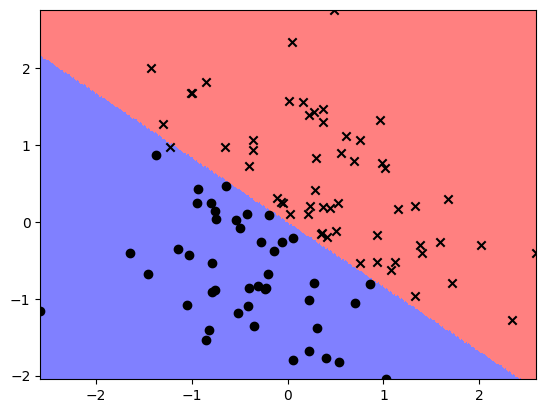

Training error: 1.0%


In [25]:
xTr,yTr = genrandomdata()
fun = primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean((torch.sign(fun(xTr))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

In [26]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    xTr = torch.tensor(xTr).float()
    yTr = torch.tensor(yTr).float()
    xTe = torch.tensor(xTe).float()
    yTe = torch.tensor(yTe).float()
    
    vals, indices = torch.max(xTr, dim=0, keepdim=True)
    xTr /= (vals * 2.0)
    vals, indices = torch.max(xTe, dim=0, keepdim=True)
    xTe /= (vals * 2.0)
    
    return xTr,yTr,xTe,yTe

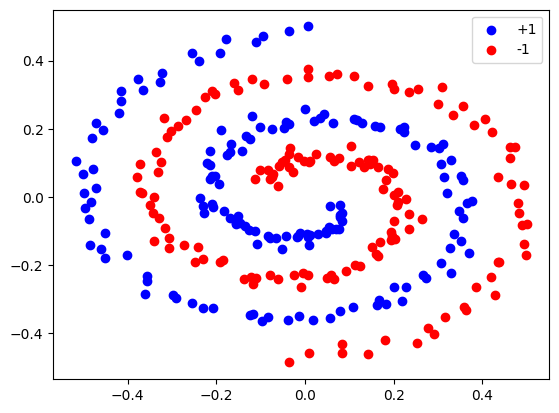

In [27]:
xTr,yTr,xTe,yTe=spiraldata()
plt.figure()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

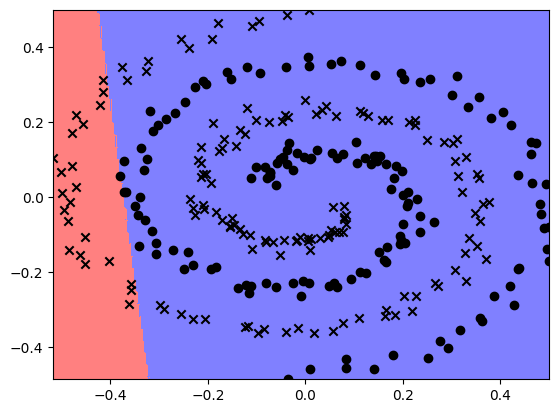

Training error: 43.0%


In [28]:
fun=primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean(((torch.sign(fun(xTr)))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

In [29]:
def computeK(kernel_type, X, Z, kpar=0.05):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kernel_type: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel Torch float tensor
    """
    assert kernel_type in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kernel_type
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    def enforce_positive_definite(K, reg=1e-6):
        n = K.shape[0]
        if n == K.shape[1]:
            return K + reg * torch.eye(n, dtype=torch.float32)
        else:
            return K
    
    if kernel_type == 'linear': 
        return enforce_positive_definite(torch.matmul(X, Z.T))
    elif kernel_type == 'rbf': 
        return enforce_positive_definite(torch.exp(-kpar*torch.pow(l2distance(X, Z), 2)))
    else: 
        return enforce_positive_definite(torch.pow(torch.matmul(X, Z.T) + 1, kpar))


torch.float32


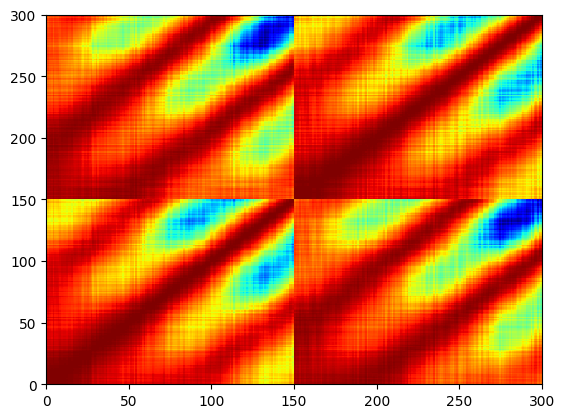

In [30]:
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("rbf",xTr,xTr,kpar=0.05)
print(K.dtype)
# plot an image of the kernel matrix
plt.figure()
plt.pcolormesh(K, cmap='jet')
plt.show()

In [475]:
class KernelizedSVM(nn.Module):
    def __init__(self, n_samples, kernel_type, kpar=0.01):
        super(KernelizedSVM, self).__init__()
        self.kernel_type = kernel_type
        self.kpar = kpar
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)
        self.beta = nn.Parameter(torch.randn(n_samples, ), requires_grad=True)
    
    def forward(self, xTr, x):
        K = computeK(self.kernel_type, xTr, x, self.kpar)        
        return K.T @ self.beta + self.b

In [476]:
def kernelsvm_loss(kernelizedSVM, kernel_mat, yTr, C):
    hinge_loss = (C / 2) * torch.sum( F.relu( 1 - yTr * ( kernel_mat @ kernelizedSVM.beta + kernelizedSVM.b ) ) ) 
    regularization_loss = 0.5 * kernelizedSVM.beta.T @ kernel_mat @ kernelizedSVM.beta

    return  hinge_loss + regularization_loss


In [477]:
def dualSVM(xTr, yTr, kernel_type, num_epochs=1000, C=10, lmbda=0, lr=1e-3):
    
    kernel_svm = KernelizedSVM(xTr.shape[0], kernel_type, kpar=lmbda)
    optimizer = optim.SGD(kernel_svm.parameters(), lr=lr)
    K = computeK(kernel_type, xTr, xTr, kpar=lmbda)  

    print_freq = num_epochs // 10
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = kernelsvm_loss(kernel_svm, K, yTr, C)
        if loss > 1e34:
            print('Loss exploded. Stopping training.')
            break
        loss.backward()
        optimizer.step()
        # if epoch % print_freq == 0:
        #     print("Epoch: %d, Loss: %f" % (epoch, loss.item()))

    return lambda x: kernel_svm.forward(xTr, x)

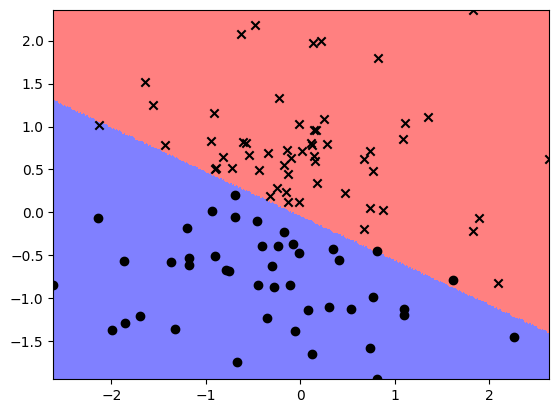

Training error: 0.0300


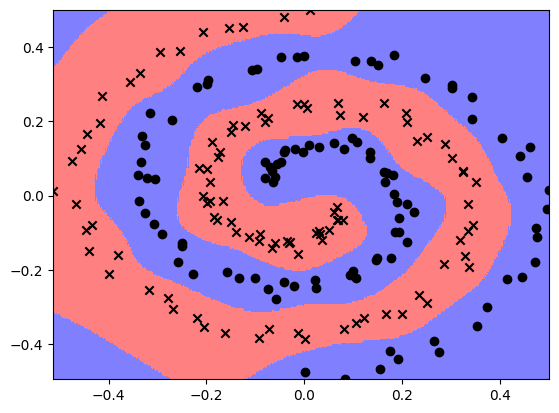

Training error: 0.0000
Testing error: 0.0050


In [478]:
# linear kernel parameters that also don't blow up vvv
xTr, yTr,  = genrandomdata()
ktype="linear"
svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=1000, C=100, lmbda=0.05, lr=1e-4)
visclassifier.visclassifier(svmclassify,xTr,yTr)
predsTr=svmclassify(xTr)
trainingerr=torch.mean((torch.sign(predsTr)!=yTr).float())

print("Training error: %2.4f" % trainingerr)



xTr,yTr,xTe,yTe=spiraldata(N=200)
# poly kernel parameters that don't blow up vvv
ktype="rbf"
svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=1000, C=100, lmbda=100, lr=1e-4)
visclassifier.visclassifier(svmclassify,xTr,yTr)

# compute training and testing error

predsTr=svmclassify(xTr)
trainingerr=torch.mean((torch.sign(predsTr)!=yTr).float())
print("Training error: %2.4f" % trainingerr)
print("Testing error: %2.4f" % torch.mean((torch.sign(svmclassify(xTe))!=yTe).float()))


In [322]:
def cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList,lr_List):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)
    
    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        lmbdaList| The list of values to try for the kernel parameter lmbda- degree for poly, inverse width for rbf (bx1)
        lr_list  | The list of values to try for the learning rate of our optimizer
    
    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        bestLr     | the best Lr parameter
        ErrorMatrix| the test error rate for each given (C, Lmbda Lr) tuple when trained on (xTr,yTr) and tested on (xValid,yValid)
    """
    
    error_matrix = torch.zeros(len(CList), len(lmbdaList), len(lr_List))
    best_idx_c, best_idx_lmbda, best_idx_lr = 0, 0, 0
    best_loss = np.inf
    
    for idx_C, C in enumerate(CList):
        for idx_lmbda, lmbda in enumerate(lmbdaList):
            for idx_lr, lr in enumerate(lr_List):
                svmclassify = dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=1000, C=C, lmbda=lmbda, lr=lr)
                preds = svmclassify(xValid)
                loss = torch.mean((torch.sign(preds)!=yValid).float())
                error_matrix[idx_C, idx_lmbda, idx_lr] = loss
                if loss < best_loss:
                    best_loss = loss
                    best_idx_c, best_idx_lmbda, best_idx_lr = idx_C, idx_lmbda, idx_lr

    bestC = CList[best_idx_c]
    bestLmbda = lmbdaList[best_idx_lmbda]
    bestLr = lr_List[best_idx_lr]

    return bestC, bestLmbda, bestLr, error_matrix

In [323]:
xTr,yTr,xValid,yValid=spiraldata(100)
CList=(2.0**np.linspace(-1,10,10))
lmbdaList=(np.linspace(1e-5,10,10))
lrList=(np.linspace(0.001,0.1,5))

bestC,bestLmbda,bestLr,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,
                                                      'rbf',CList,lmbdaList,
                                                      lrList)

Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded. Stopping training.
Loss exploded.

KeyboardInterrupt: 

In [ ]:
def train_test_split(X, y):
    n = X.shape[0]
    train_idx = np.random.choice(n, int(n * 0.8), replace=False)
    test_idx = np.setdiff1d(np.arange(n), train_idx)
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

In [ ]:
def standardize_X(xTr):
    """
    Standardizes the data by subtracting the mean and dividing by the standard deviation.
    """
    xTr = xTr - torch.mean(xTr, dim=0)
    xTr = xTr / torch.std(xTr, dim=0)
    return xTr

In [ ]:
class StandardizedKernelSVM(nn.Module):
    def __init__(self, xTr, kernel_type, kpar=0.1):
        super(StandardizedKernelSVM, self).__init__()
        n_samples = xTr.shape[0]
        self.kernel_type = kernel_type
        self.kpar = kpar
        self.beta = nn.Parameter(torch.randn(n_samples,), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)
        self.X_mu = torch.mean(xTr, dim=0)
        self.X_std = torch.std(xTr, dim=0)
        self.xTr = self.standardize_X(xTr)
    
    def standardize_X(self, X):
        return (X - self.X_mu) / self.X_std

    def forward(self, x):
        x = self.standardize_X(x)
        K = computeK(self.kernel_type, self.xTr, x, self.kpar)
       
        return K.T @ self.beta + self.b

In [536]:
def standardized_dualSVM(xTr, yTr, kernel_type, num_epochs=1000, C=10, lmbda=0, lr=1e-2):

    strd_kernel_svm = StandardizedKernelSVM(xTr, kernel_type, kpar=lmbda)
    optimizer = optim.SGD(strd_kernel_svm.parameters(), lr=lr)
    
    K = computeK(kernel_type, strd_kernel_svm.xTr, strd_kernel_svm.xTr, lmbda)

    for _ in range(num_epochs):
        optimizer.zero_grad()
        loss = kernelsvm_loss(strd_kernel_svm, K, yTr, C)
        loss.backward()
        optimizer.step()

        if loss > 1e20:
            break
      
    return lambda x: strd_kernel_svm.forward(x)
    

In [537]:
def efficient_grid_search(xTr, yTr, lmbda_list, c_list, lr_list=(0.01)):
    """ 
    Finds a hyperparameter configuration that minimizes the validation error below
    a certain threshold.  The best classifier is then returned as soon as the validation loss 
    is below the threshold.  This is a more efficient way to search for hyperparameters than
    a brute force search.
    """
    best_loss = np.inf
    best_params = None
    threshold = 0.05

    for lmbda in lmbda_list:
        for c in c_list:
            for lr in lr_list:
                svmclassify = standardized_dualSVM(xTr, yTr, kernel_type='rbf', num_epochs=1000, C=c, lmbda=lmbda, lr=lr)
                preds = svmclassify(xValid)
                loss = torch.mean((torch.sign(preds)!=yValid).float())
                if loss < best_loss:
                    best_loss = loss
                    best_params = (lmbda, c, lr)
                if loss < threshold:
                    print('Validation loss below threshold.  Returning best model.')
                    return best_params
    return best_params

In [538]:
def lmbda_bound_rbf(xTr, min_k_val=torch.tensor(0.1)):
    """ 
    min_exp=0.01
    Computes the lower bound on lambda for the RBF kernel.
    
    Paramters:
    ----------
    xTr: torch.Tensor
    min_exp: float (default: 0.1)

    Returns:
    --------
    lmbda_lower_bound: torch.Tensor
    lmbda_upper_bound: torch.Tensor
    """
    
    distances = l2distance(xTr, xTr)
    d_max = torch.max(distances)
    lower_bnd = -torch.log(min_k_val) / d_max

    return lower_bnd 

In [539]:
def autosvm(xTr,yTr):
    """
    svmclassify = autosvm(xTr,yTr), where yTe = svmclassify(xTe)
    """
    xTr_copy = xTr.clone()
    xTr_copy = standardize_X(xTr_copy)    
   
    # lmbda_lower = lmbda_bound_rbf(xTr_copy)  
    # #print('lmbda lower bound: ', lmbda_lower)
    # lmbdaList=(np.linspace(lmbda_lower, 5*lmbda_lower,20) )
    # CList = ( np.linspace(0.1, 5, 10) )
    CList = (2**np.linspace(-5, 15, 21) )
    lrList=(2**np.linspace(-15,3,19))
    print('lmbdaList: ', lmbdaList)
    print('CList: ', CList)
    
    bestLmbda, bestC, bestLr = efficient_grid_search(xTr, yTr, lmbdaList, CList, lrList)


    print(f"bestC = {round(bestC,3)}, bestLmbda = {round(bestLmbda,4)}, bestLr = {round(bestLr,3)}")
    
    return standardized_dualSVM(xTr, yTr, kernel_type='rbf', num_epochs=1000, C=bestC, lmbda=bestLmbda, lr=bestLr)

In [540]:
for data_func in [generate_spiral_data, generate_imbalanced_data, generate_noisy_data, generate_block_data]:
    X, y = data_func(300)
    X = X / 10000
    x_train, x_test, y_train, y_test = train_test_split(X, y)

    svmclassify=autosvm(x_train,y_train)
    visclassifier.visclassifier(svmclassify,X,y)
    
    predsTr=svmclassify(x_train)
    trainingerr=torch.mean((torch.sign(predsTr)!=y_train).float())
    print("Training error: %2.4f" % trainingerr)
    
    predsTe=svmclassify(x_test)
    testingerr=torch.mean((torch.sign(predsTe)!=y_test).float())
    print("Testing error: %2.4f" % testingerr)

lmbdaList:  [1.00000e-05 1.11112e+00 2.22223e+00 3.33334e+00 4.44445e+00 5.55556e+00
 6.66667e+00 7.77778e+00 8.88889e+00 1.00000e+01]
CList:  [3.1250e-02 6.2500e-02 1.2500e-01 2.5000e-01 5.0000e-01 1.0000e+00
 2.0000e+00 4.0000e+00 8.0000e+00 1.6000e+01 3.2000e+01 6.4000e+01
 1.2800e+02 2.5600e+02 5.1200e+02 1.0240e+03 2.0480e+03 4.0960e+03
 8.1920e+03 1.6384e+04 3.2768e+04]


lmbda lower bound:  tensor(0.4536)
bestC = 42.395, bestLmbda = 1.5278, bestLr = 0.001


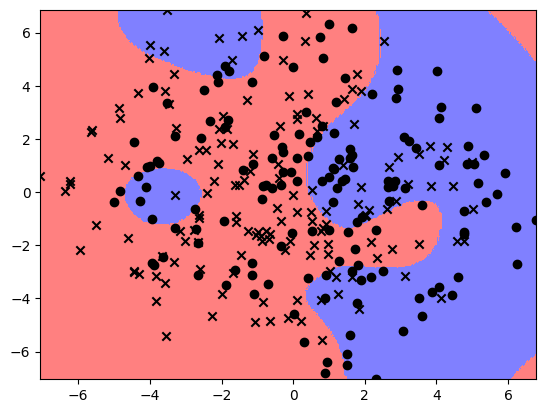

Training error: 0.3833
Testing error: 0.4000


In [ ]:

X, y = generate_test_set()
x_train, x_test, y_train, y_test = train_test_split(X, y)

svmclassify=autosvm(x_train,y_train)
visclassifier.visclassifier(svmclassify,X,y)

predsTr=svmclassify(x_train)
trainingerr=torch.mean((torch.sign(predsTr)!=y_train).float())
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(x_test)
testingerr=torch.mean((torch.sign(predsTe)!=y_test).float())
print("Testing error: %2.4f" % testingerr)


